# LANL Earthquakes Experiment
# Spectrogram Analysis

Original source:
[[1]](https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89)
[[2]](https://github.com/sevenfx/fastai_audio)

#### Main contents:

- Display data
- Display FFT of various segments and computation methods (in particular batch alignment does not look important)
- Spectrograms: first attempt
- Spectrograms: second attempt (in particular try to better express range of signal values and have more variance in colors)
- Generate spectrograms and save to disk

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
import librosa
import librosa.display

## Load and show data

In [5]:
BASE = Path('../Data')
n = int(150e3)

df = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=None,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df2 = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=range(1,int(2.2e6)),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df2.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df_peak = pd.read_csv(BASE/'train.csv', nrows=n, skiprows=range(1,int(4.4e6)),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_peak.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

In [6]:
print(df.head())
print(df.info())
print(df.describe())

   signal  quaketime
0      12     1.4691
1       6     1.4691
2       8     1.4691
3       5     1.4691
4       8     1.4691
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
signal       150000 non-null int16
quaketime    150000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 1.4 MB
None
              signal      quaketime
count  150000.000000  150000.000000
mean        4.884113       1.450182
std         5.101106       0.011248
min       -98.000000       1.430797
25%         3.000000       1.440398
50%         5.000000       1.449999
75%         7.000000       1.459599
max       104.000000       1.469100


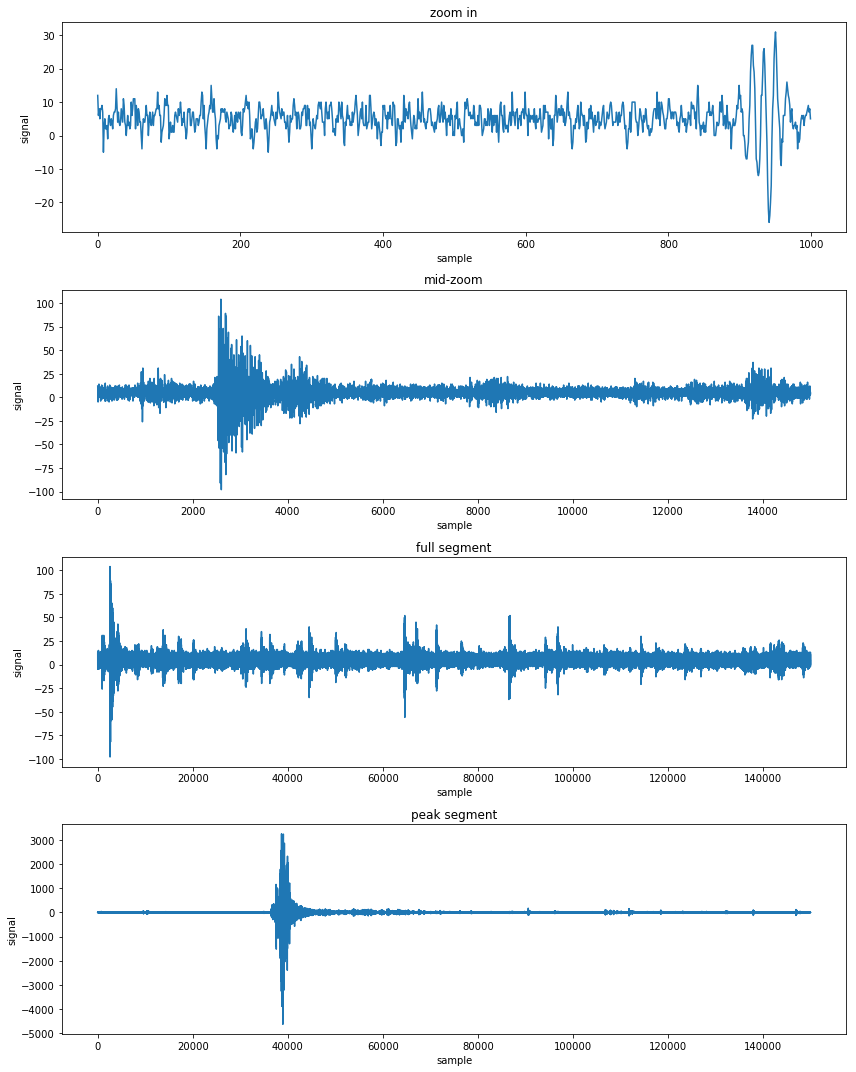

In [7]:
fig,axs = plt.subplots(4,1, figsize=(12,15))
axs[0].plot(df.signal.head(1000))
axs[1].plot(df.signal.head(15000))
axs[2].plot(df.signal.head(150000))
axs[3].plot(df_peak.signal)
for i,ax in enumerate(axs):
    ax.set_title(('zoom in','mid-zoom','full segment','peak segment')[i])
    ax.set_xlabel('sample')
    ax.set_ylabel('signal')
plt.tight_layout()

## Basic FFT
Note: there're suspected discontinuities in sampling times every 4096 samples ("batches"), so we find these discontinuities and compare batches FFTs with & without alignment to the discontinuity. Looks like the discontinuity does not noticably ruin the FFT, at least in the first 150K-samples segment.

In [8]:
def get_batches(df, verbose=True):
    dt = np.median(np.diff(-df.quaketime))
    transitions = np.where(np.logical_or(
        np.diff(-df.quaketime)>10*dt, np.diff(-df.quaketime)<-10*dt) )[0] + 1
    transitions = np.concatenate(([0], transitions, [len(df)]))
    if verbose:
        print('Distribution of blocks lengths:')
        l = [tf-ti for ti,tf in zip(transitions[:-1],transitions[1:])]
        print(tuple((g[0], len(list(g[1]))) for g in itertools.groupby(sorted(l))))
        print(f'Valid blocks (4096 samples):\t' +
              f'{np.sum(np.diff(transitions)==4096):.0f}/{len(l):d}')
    return transitions

transitions = get_batches(df)
transitions = get_batches(df_peak)

Distribution of blocks lengths:
((2545, 1), (4095, 1), (4096, 35))
Valid blocks (4096 samples):	35/37
Distribution of blocks lengths:
((3200, 1), (3440, 1), (4096, 35))
Valid blocks (4096 samples):	35/37


#### Standard segment

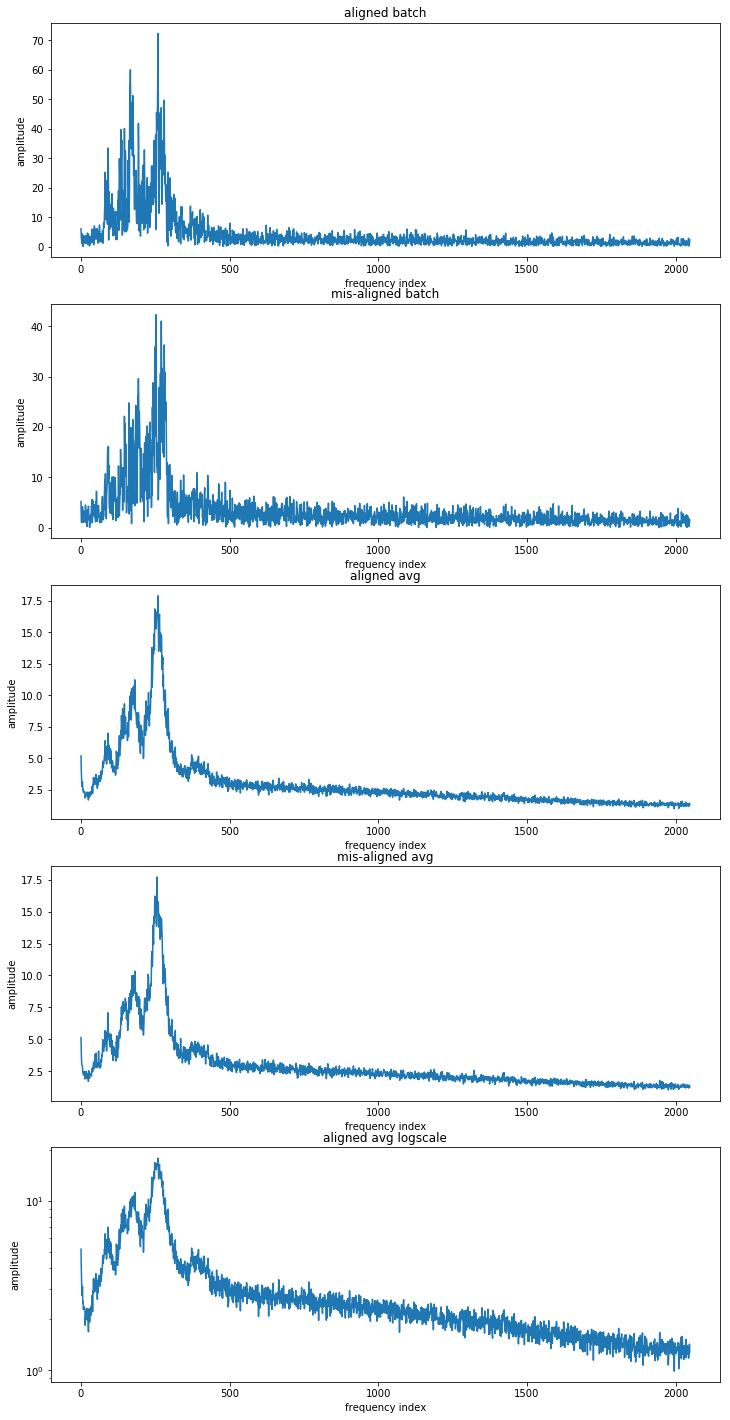

In [9]:
def batches_fft(df, transitions, offset=0):
    ffts = []
    for ti,tf in zip(transitions[:-1]+offset,transitions[1:]+offset):
        if tf-ti != 4096 or tf>=len(df): continue
        f = np.fft.rfft(df.signal[ti:tf], norm='ortho')[1:]
        ffts.append(np.abs(f))
    avg_fft = np.mean(ffts, axis=0)
    return (avg_fft, ffts)

ffts_aligned = batches_fft(df, transitions)
ffts_misaligned = batches_fft(df, transitions, 1000)

fig,axs = plt.subplots(5,1, figsize=(12,25))
axs[0].plot(ffts_aligned[1][0])
axs[1].plot(ffts_misaligned[1][0])
axs[2].plot(ffts_aligned[0])
axs[3].plot(ffts_misaligned[0])
axs[4].plot(ffts_aligned[0])
axs[4].set_yscale('log')
titles = ('aligned batch','mis-aligned batch','aligned avg','mis-aligned avg','aligned avg logscale')
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel('frequency index')
    ax.set_ylabel('amplitude')

#### Peak segment

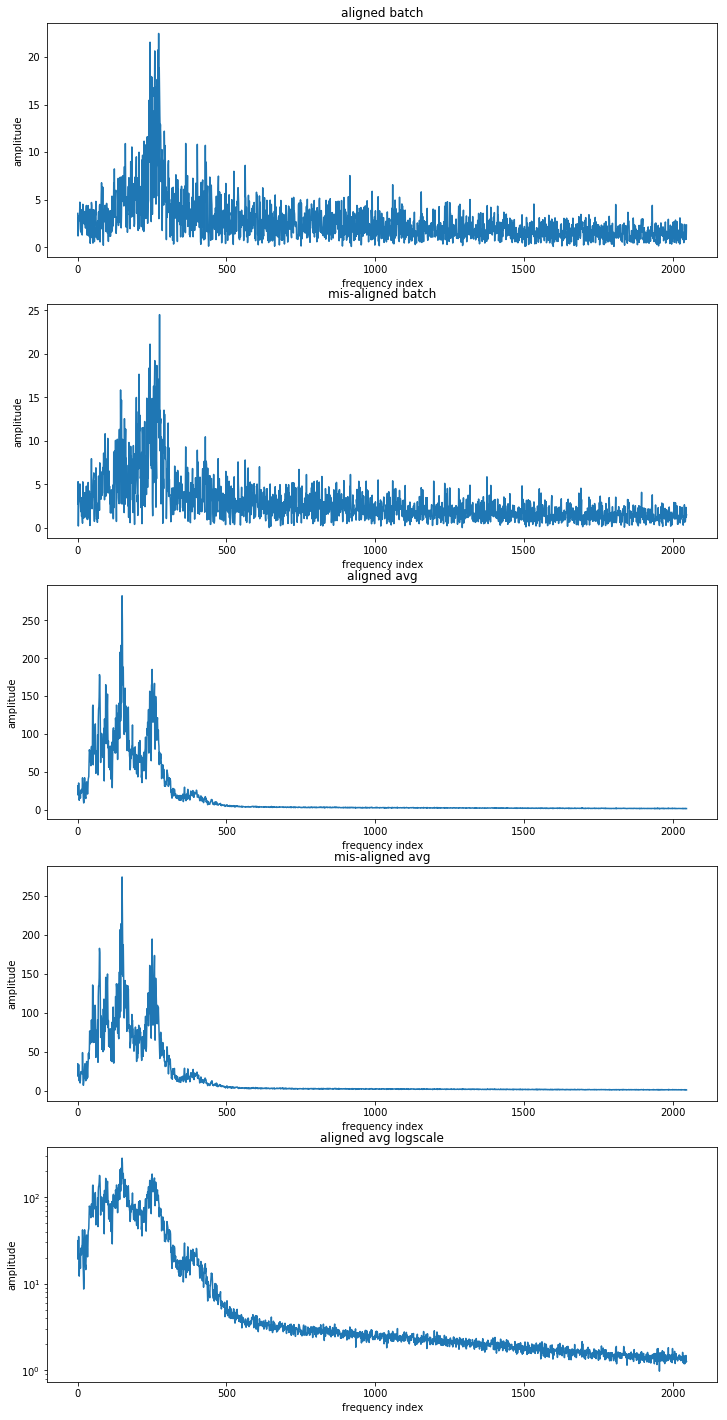

In [10]:
ffts_aligned = batches_fft(df_peak, transitions)
ffts_misaligned = batches_fft(df_peak, transitions, 1000)

fig,axs = plt.subplots(5,1, figsize=(12,25))
axs[0].plot(ffts_aligned[1][0])
axs[1].plot(ffts_misaligned[1][0])
axs[2].plot(ffts_aligned[0])
axs[3].plot(ffts_misaligned[0])
axs[4].plot(ffts_aligned[0])
axs[4].set_yscale('log')
titles = ('aligned batch','mis-aligned batch','aligned avg','mis-aligned avg','aligned avg logscale')
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel('frequency index')
    ax.set_ylabel('amplitude')

## Spectrogram

Check linear vs. log frequency & linear vs. log power, in both "standard" and "peak" segments.

log power and log frequency look like the best images.

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


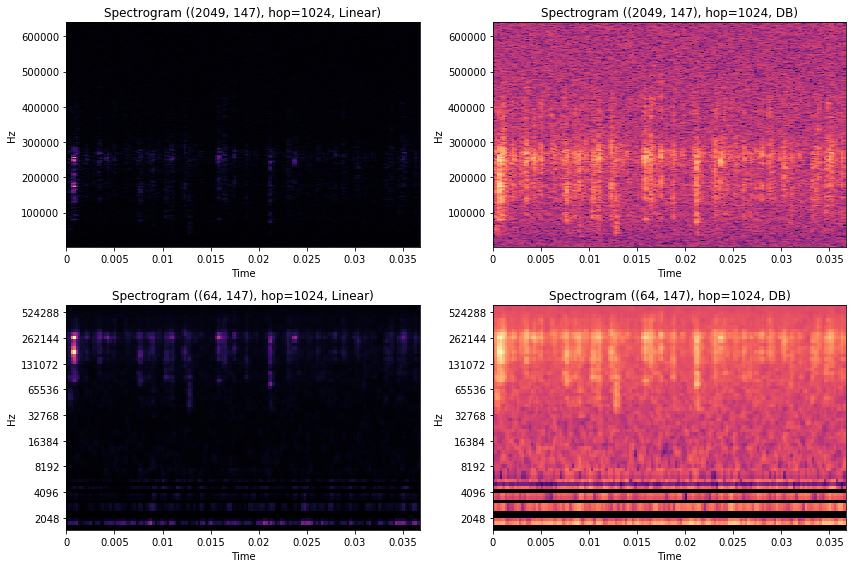

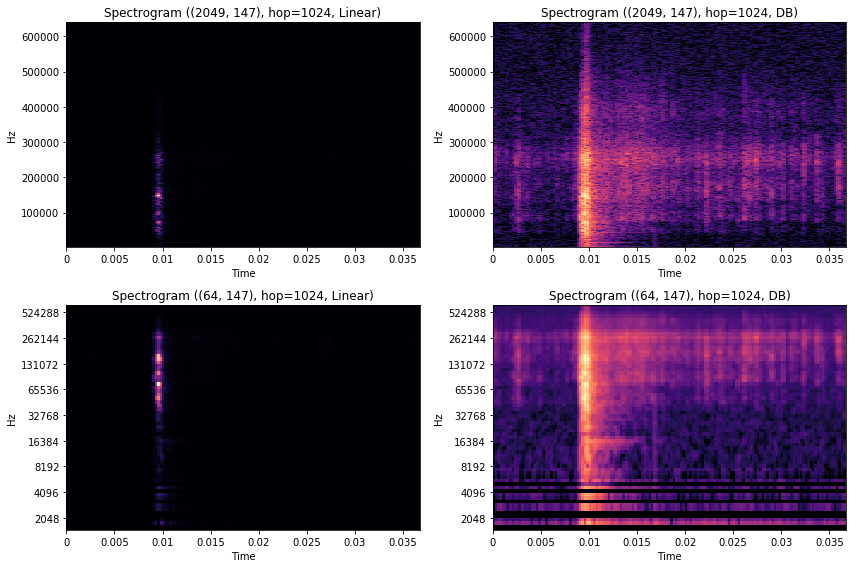

In [11]:
# Note - alternative plot code: plt.specgram(np.array(df.signal,dtype='float'), NFFT=4096, noverlap=2048, Fs=4096e3)
def plot_spec(df, n_fft=4096, hop_length=1024, sr=4096e3, n_mels=64, fmin=1480, fmax=640e3):
    stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)

    fig,axs = plt.subplots(2,2, figsize=(12,8))
    librosa.display.specshow(stft_magnitude, ax=axs[0,0], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,0].set_ylim((fmin,fmax))
    axs[0,0].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, Linear)')

    librosa.display.specshow(stft_magnitude_db, ax=axs[0,1], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,1].set_ylim((fmin,fmax))
    axs[0,1].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, DB)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    librosa.display.specshow(mel_spec, ax=axs[1,0], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,0].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, Linear)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec, ax=axs[1,1], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,1].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, DB)')
    
    plt.tight_layout()

plot_spec(df)
plot_spec(df_peak)

Mels are logarithmically-wide frequency bands with universally-conventional values. They are used to convert audio signal to logarithmic frequency-scale. In the earthquakes non-conventional audio signal, the mel scale corrupts the spectrogram and creates the black lines that can be seen above.
Thus, we probably need to either change the whole Mel scale (which doesn't seem to be supported in librosa library) or use fictive sample rate.

A sample rate of 44KHz (instead of 4MHz) was chosen along with the rest of the spectrogram parameters as can be seen below. They all were chosen by trying several values and visually judging the resulted image.

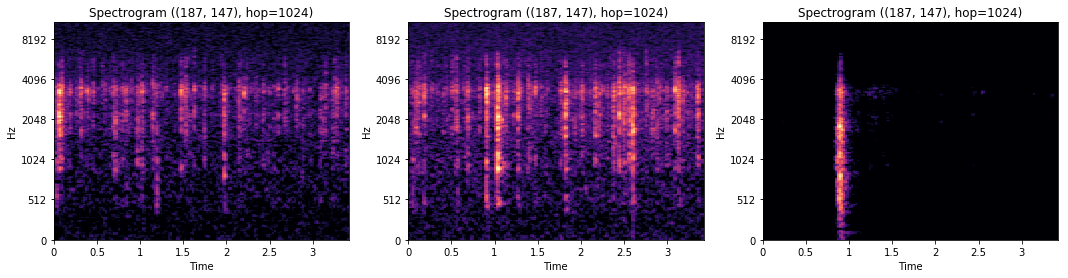

In [12]:
def plot_spec(dfs, n_fft=4096, hop_length=None, sr=44e3, n_mels=256, fmin=0, fmax=128e3, power=2.0, lin=False):
    if hop_length is None:
        hop_length = n_fft // 4
    fig,axs = plt.subplots(1+lin,len(dfs), figsize=(6*len(dfs),4+4*lin))
    for i,df in enumerate(dfs):
        ax = axs[0,i] if lin else axs[i]
        mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
        mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
        l = mel_spec.shape[0]
        mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel', 
                                 sr=sr, hop_length=hop_length)#, fmin=fmin, fmax=fmax)
        ax.set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d})')
        
        if lin:
            ax = axs[1,i]
            stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
            stft_magnitude, stft_phase = librosa.magphase(stft)
            stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
            librosa.display.specshow(stft_magnitude_db, ax=ax, x_axis='time', y_axis='linear', 
                                     sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
            ax.set_ylim((fmin,fmax))
            ax.set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d})')


plot_spec((df,df2,df_peak), sr=44e3, n_fft=4096, n_mels=256, power=2.0)

## Spectrogram scale research

Saved spectrogram files currently have similar range of colors even when the original signals are of very different scale.

### Try librosa features for nicely-visualized spectrograms

In [13]:
# Get 20 random 150K-long-segments from train data.

dfs = []
for off in tqdm_notebook(np.random.randint(0,100000000,20)):
    dfs.append(pd.read_csv(BASE/'train.csv', nrows=n, skiprows=range(1,1+off),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}))
    dfs[-1].rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

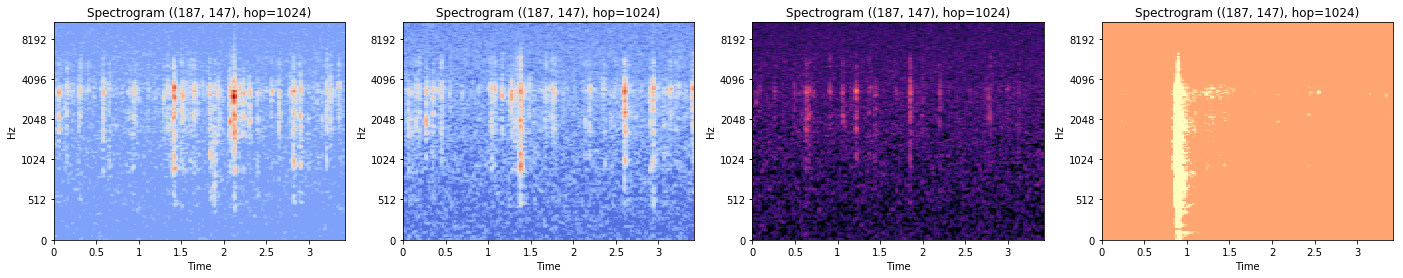

In [14]:
# Create spectrograms and display them.
# Segments: some of the random segments from above + one peak segment.
# New features:
#   amplitude_to_db(..., ref=const) # instead of ref=np.max
#   specshow(..., vmin=-50, vmax=50) # force image to be scaled wrt const standard
#   use plt.savefig() that saves the displayed figure, rather than plt.imsave() that saves the matrix.

def plot_spec(dfs, n_fft=4096, hop_length=None, sr=44e3, n_mels=256, fmin=0, fmax=128e3, power=2.0, lin=False, nm='hello'):
    if hop_length is None:
        hop_length = n_fft // 4
    fig,axs = plt.subplots(1+lin,len(dfs), figsize=(6*len(dfs),4+4*lin))
    S = []
    M = []
    for i,df in enumerate(dfs):
        ax = axs[0,i] if lin else axs[i]
        mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
        tmp = mel_spec
        mel_spec = librosa.amplitude_to_db(mel_spec, ref=10**8)
        l = mel_spec.shape[0]
        mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel', vmin=-50, vmax=50,
                                 sr=sr, hop_length=hop_length)#, fmin=fmin, fmax=fmax)
        ax.set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d})')
#         #plt.imsave(f'spec_{nm:s}_{i:d}.png', mel_spec)
#         fig = plt.figure(figsize=(2.6,2.6))
#         fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
#         librosa.display.specshow(mel_spec, ax=plt.axes(), x_axis='time', y_axis='mel', vmin=-50, vmax=50,
#                                  sr=sr, hop_length=hop_length)#, fmin=fmin, fmax=fmax)
#         plt.axes().set_axis_off()
#         #plt.savefig(f'spec_{nm:s}_{i:d}_basic.png')
#         plt.savefig(f'spec_{nm:s}_{i:d}_advanced.png', bbox_inches='tight', transparent=True, pad_inches=0.0)
#         plt.close()
        
        S += [tmp]
        M += [mel_spec]
    return S,M


# S1,M1 = plot_spec((df,df2,df_peak), sr=44e3, n_fft=4096, n_mels=256, power=2.0, nm='chosen')
# S2,M2 = plot_spec(dfs[7:10], sr=44e3, n_fft=4096, n_mels=256, power=2.0, nm='rand')
S,M = plot_spec((*dfs[7:10],df_peak), sr=44e3, n_fft=4096, n_mels=256, power=2.0, nm='rand')

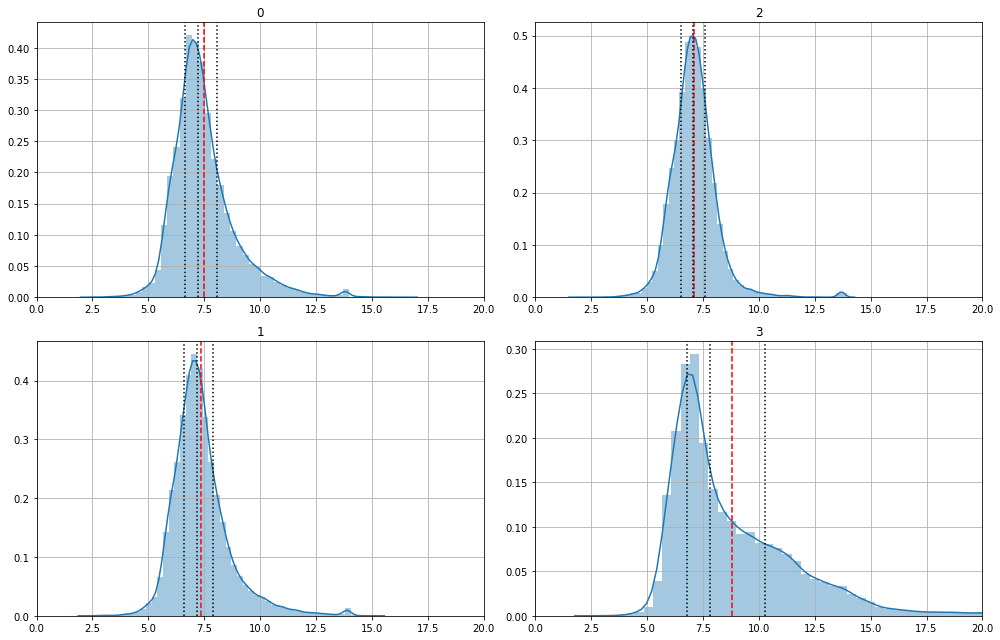

In [21]:
# The power of the spectrogram-arrays of the segments indeed have different distributions
# that seem to relate to the visualizations above.

fig, axs = plt.subplots(2,2, figsize=(14,9))
for i,m in enumerate(S):
    ax = axs[i%2,i//2]
    sns.distplot(np.log(m.flatten()), ax=ax)
    ax.set_xlim((0,20))
    ax.set_title(i)
    ax.axvline(np.mean(np.log(m.flatten())), color='r', linestyle='--')
    ax.axvline(np.quantile(np.log(m.flatten()),0.25), color='k', linestyle=':')
    ax.axvline(np.quantile(np.log(m.flatten()),0.5), color='k', linestyle=':')
    ax.axvline(np.quantile(np.log(m.flatten()),0.75), color='k', linestyle=':')
    ax.grid()
plt.tight_layout()

### Make sure that new spectrograms reflect signal scale reasonably

In [27]:
from scipy.misc import imread
n_fft=4096
hop_length=None
sr=44e3
n_mels=256
fmin=0
fmax=128e3
power=2.0
class_limits=(0,1,2,3,4,5,6,7,8,10,12,99)

In [37]:
# Get 20 random segments, generate their spectrogram-arrays, and load their saved PNG-spectrograms.

np.random.seed(0)
sigs = []
specs = []
mels = []
ims = []
hops = np.random.randint(0,3000,20)
for hop in hops:
    tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                      nrows=seg_len, skiprows=range(1,1+hop*hop_len))
    tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
    sigs.append(tmp.signal.values)
    tf = tmp.quaketime.values[-1]
    cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
    cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
    fname = str(hop) + '_' + cls_nm + '.png'
    ims.append(imread(TRAIN/fname))
    mel_spec = librosa.feature.melspectrogram(np.array(tmp.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
    specs.append(mel_spec)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=10**8)
    l = mel_spec.shape[0]
    mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
    mels.append(mel_spec)
    

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [55]:
# Get also the peak segment and its spectrogram.

tmp = df_peak

sigs.append(tmp.signal.values)
tf = tmp.quaketime.values[-1]
cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
fname = str(hop) + '_' + cls_nm + '.png'
ims.append(imread(TRAIN/fname))
mel_spec = librosa.feature.melspectrogram(np.array(tmp.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                      n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
specs.append(mel_spec)
mel_spec = librosa.amplitude_to_db(mel_spec, ref=10**8)
l = mel_spec.shape[0]
mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
mels.append(mel_spec)
ims.append(imread(TRAIN/'1954_00-01.png'))

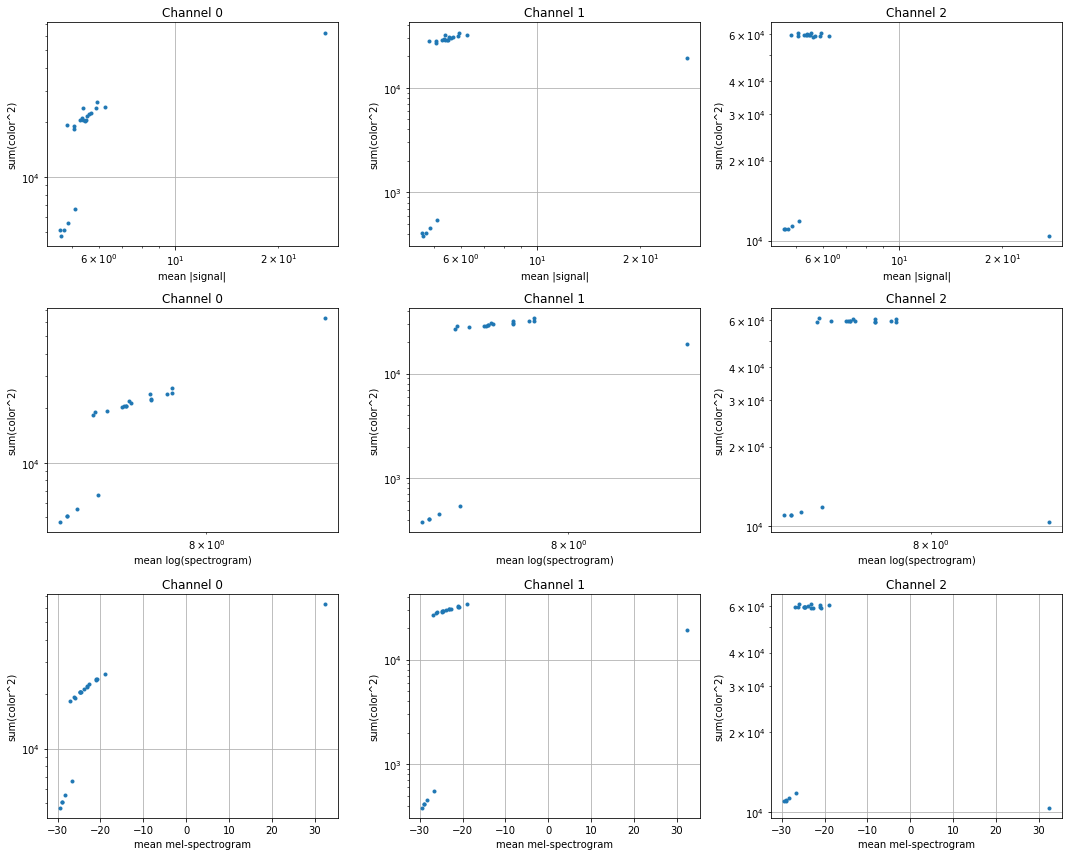

In [65]:
# Look for relation between the signal "power"
# (measured by mean(|signal|), mean(log(raw spectrogram)), and mean(mel-spectrogram))
# and the PNG image color range (measured by sum(color^2) for each channel separately).

fig, axs = plt.subplots(3,3, figsize=(15,12))
for channel in range(3):
    axs[0,channel].plot([np.mean(np.abs(m.flatten())) for m in sigs],[np.mean(([t**2 for t in im[:,:,channel].flatten()])) for im in ims],'.')
    axs[0,channel].set_xlabel('mean |signal|')
    axs[0,channel].set_ylabel('sum(color^2)')
    axs[0,channel].set_title(f'Channel {channel:d}')
    axs[0,channel].set_xscale('log')
    axs[0,channel].set_yscale('log')
    axs[0,channel].grid()
    axs[1,channel].plot([np.mean(np.log(m.flatten())) for m in specs],[np.mean(([t**2 for t in im[:,:,channel].flatten()])) for im in ims],'.')
    axs[1,channel].set_xlabel('mean log(spectrogram)')
    axs[1,channel].set_ylabel('sum(color^2)')
    axs[1,channel].set_title(f'Channel {channel:d}')
    axs[1,channel].set_xscale('log')
    axs[1,channel].set_yscale('log')
    axs[1,channel].grid()
    axs[2,channel].plot([np.mean((m.flatten())) for m in mels],[np.mean(([t**2 for t in im[:,:,channel].flatten()])) for im in ims],'.')
    axs[2,channel].set_xlabel('mean mel-spectrogram')
    axs[2,channel].set_ylabel('sum(color^2)')
    axs[2,channel].set_title(f'Channel {channel:d}')
    #axs[2,channel].set_xscale('log')
    axs[2,channel].set_yscale('log')
    axs[2,channel].grid()
plt.tight_layout()

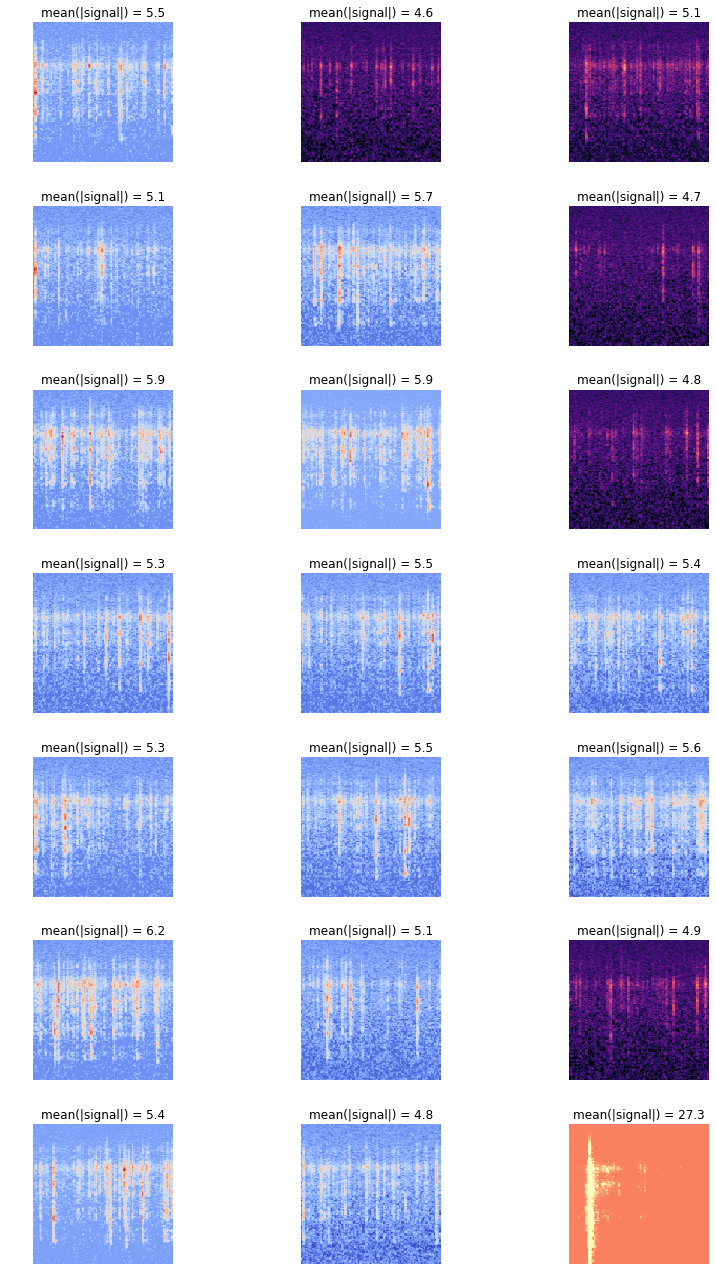

In [70]:
fig, axs = plt.subplots(7,3, figsize=(12,18))

for i,(s,im) in enumerate(zip(sigs,ims)):
    ax = axs[i%7,i//7]
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f'mean(|signal|) = {np.mean(np.abs(s.flatten())):.1f}')

plt.tight_layout()

**IT LOOKS LIKE THE FIRST CHANNEL INDEED ENCODES THE POWER REASONABLY-MONOTONOUSLY.**

It also looks like there's some arbitrary dis-continuity in colors vs. power. Not sure if it should be a problem.

### tmp code

In [66]:
# fig, axs = plt.subplots(2,2, figsize=(14,9))
# for i,m in enumerate(M):
#     ax = axs[i%2,i//2]
#     sns.distplot((m.flatten()), ax=ax)
#     ax.set_xlim((-50,50))
#     ax.set_title(i)
#     ax.axvline(np.mean((m.flatten())), color='r', linestyle='--')
#     ax.axvline(np.quantile((m.flatten()),0.25), color='k', linestyle=':')
#     ax.axvline(np.quantile((m.flatten()),0.5), color='k', linestyle=':')
#     ax.axvline(np.quantile((m.flatten()),0.75), color='k', linestyle=':')
#     ax.grid()
# plt.tight_layout()

In [13]:
# # power order: 2, 1, 3, 0, 4, 5

# fig, axs = plt.subplots(3,2, figsize=(14,9))
# for i,m in enumerate(S1+S2):
#     sns.distplot(np.log(m.flatten()), ax=axs[i%3,i//3])
#     axs[i%3,i//3].set_xlim((0,20))
#     axs[i%3,i//3].set_title(i)
# plt.tight_layout()

In [14]:
# fig, axs = plt.subplots(3,2, figsize=(14,9))
# for i,m in enumerate(M1+M2):
#     sns.distplot((m.flatten()), ax=axs[i%3,i//3])
#     axs[i%3,i//3].set_xlim((-50,50))
#     axs[i%3,i//3].set_title(i)
# plt.tight_layout()

In [15]:
# print([((np.min(m)),(np.log(np.max(m)))) for m in M2])
# for i,m in enumerate(M[:2]):
#     sns.distplot(m.flatten(), label=i)
# plt.legend()
# #plt.yscale('log')

In [16]:
# for M in (M1,M2):
#     plt.figure()
#     sns.distplot([(np.min(m)) for m in M])
#     plt.figure()
#     sns.distplot([(np.median(m)) for m in M])
#     plt.figure()
#     sns.distplot([(np.mean(m)) for m in M])
#     plt.figure()
#     sns.distplot([(np.max(m)) for m in M])

In [17]:
# for M in (S1,S2):
#     plt.figure()
#     sns.distplot([np.log(np.min(m)) for m in M])
#     plt.figure()
#     sns.distplot([np.log(np.median(m)) for m in M])
#     plt.figure()
#     sns.distplot([np.log(np.mean(m)) for m in M])
#     plt.figure()
#     sns.distplot([np.log(np.max(m)) for m in M])

## Generate spectrograms data

In [23]:
BASE = Path('../Data')
TRAIN = BASE/'train_spec3'

n_all = 629145480 # df_full.shape[0]
seg_len = int(150e3)
hop_len = int(25e3) # try even 10e3?
n_hops = int(n_all/hop_len)
segs_to_read = 1050
hops_to_read = int(segs_to_read * seg_len/hop_len)

Read train data in 4 chunks of 1K segments;
save each segment's spectrogram (as png file);
and keep a table of segments and their quaketimes:

Updated to 8.5.19.

,filename,time,class
0,0_01-02.png,1.430797,01-02
1,1_01-02.png,1.424497,01-02
2,2_01-02.png,1.418096,01-02
3,3_01-02.png,1.411696,01-02
4,4_01-02.png,1.404200,01-02


<Figure size 187.2x187.2 with 0 Axes>

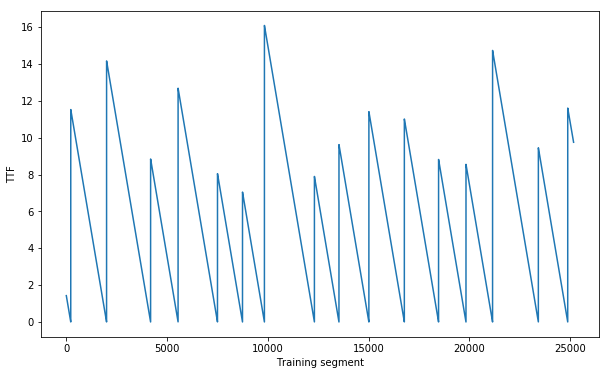

In [23]:

meta = pd.DataFrame(columns=('filename','time','class'))#,'mean','var'))

def save_spec(df, seg_index, meta, class_limits=(0,1,2,3,4,5,6,7,8,10,12,99), base_path=TRAIN,
              n_fft=4096, hop_length=1024, sr=44e3, n_mels=256, power=2.0, fig=None):#, fmin=1480, fmax=640e3):
    tf = df.quaketime.values[-1]
    cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
    cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
    fname = str(seg_index) + '_' + cls_nm + '.png'
    
    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=10**8)
    l = mel_spec.shape[0]
    mel_spec = mel_spec[int(0.02*l):int(0.75*l),:]
    meta.loc[seg_index] = [fname, tf, cls_nm, np.mean(mel_spec), np.var(mel_spec)]
    
    if fig is None:
        fig = plt.figure(figsize=(2.6,2.6))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    librosa.display.specshow(mel_spec, ax=plt.axes(), x_axis='time', y_axis='mel', vmin=-50, vmax=50,
                             sr=sr, hop_length=hop_length)
    plt.axes().set_axis_off()
    plt.savefig(base_path/fname)
    plt.clf()
    #plt.close()
    
    #plt.imsave(base_path/fname, mel_spec)



GENERATE_SPECTS = False

if GENERATE_SPECTS:
    fig = plt.figure(figsize=(2.6,2.6))
    for i in tqdm_notebook(range(n_hops)):
        if i % hops_to_read == 0:
            tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                              nrows=seg_len*(segs_to_read+1), skiprows=range(1,1+i*hop_len))
            tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
        save_spec(tmp[(i%hops_to_read)*hop_len:(i%hops_to_read)*hop_len+seg_len], i, meta, fig=fig)

    meta.to_csv(TRAIN/'train_spec_meta.csv', index=False)
else:
    meta = pd.read_csv(TRAIN/'train_spec_meta.csv')
    
plt.figure(figsize=(10,6))
plt.plot(meta.time)
plt.xlabel('Training segment')
plt.ylabel('TTF')
meta.head()